In [2]:
#!rm -rf ~/.cache/torch/transformers
#!ls -als  ~/.cache/torch/transformers
#!pip uninstall transformers -y
#!pip uninstall torch -y
#!pip install torch
#!pip install transformers 

In [3]:
import os
import torch
import pandas as pd
import numpy as np
import warnings
from transformers import (
    AutoTokenizer, AutoModelWithLMHead, GPT2Tokenizer,GPT2LMHeadModel,
    TextDataset,DataCollatorForLanguageModeling,LineByLineTextDataset,
    Trainer, TrainingArguments,
    WEIGHTS_NAME, CONFIG_NAME
)
#warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', None)
output_dir="./4-train-gpt2-en-toke-en-tweets-der"
pre_trained = 'gpt2'
train_path = 'train_dataset_der.txt'
test_path = 'test_dataset_der.txt'

## Solo si queremos entrenar de nuevo, borramos el directorio con artefactos

In [2]:
#!rm -rf {output_dir}

In [3]:
tokenizer = GPT2Tokenizer.from_pretrained(pre_trained, force_download=True, cache_dir = output_dir )
tokenizer.pad_token = tokenizer.eos_token
print(tokenizer.eos_token)


#print('Train')
#!head -c 1000 {train_path}
#print('\n\nTest')
#!head -c 1000 {test_path}
#print('\n')


<|endoftext|>


In [13]:
def load_dataset(train_path,test_path,tokenizer):
    train_dataset = TextDataset(
        tokenizer=tokenizer,
        file_path=train_path,
        block_size=500
    )

    test_dataset = TextDataset(
        tokenizer=tokenizer,
        file_path=test_path,
        block_size=500
    )
    
    data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)
    
    return train_dataset,test_dataset,data_collator

train_dataset,test_dataset,data_collator = load_dataset(train_path,test_path,tokenizer)

In [14]:
base_index= 0
tokenizer.decode(train_dataset[base_index+0]),tokenizer.decode(train_dataset[base_index+1]), tokenizer.decode(train_dataset[base_index+2]), tokenizer.decode(train_dataset[base_index+3])

('#BuenasNoticias  de nuestro Pdte @sebastianpinera La #NuevaLeydeArriendos agilizará los juicios de arrendamiento y protegerá a los ciudadanos ante los arriendos a abusivos. La #NuevaLeydeArriendos también establecerá la figura de arriendo, subarriendo abusivo  Lamentablemente hoy la región recibió dos noticias que nos enlutan: el fallecimiento del fiscal Cristian Oróstica y un segundo femicidio en Lota. En nombre de la Intendencia y el Gobierno Regional envío sentidas condolencias a sus familias que están viviendo un duro momento.  Aquí la oposición hace festín con el aumento d casos Covid y escarba para aumentar las muertes artificialmente, pero el ícono d los Izquierdistas Maduro, en Vnzla. se proclama el mejor para contener la pandemia declarando sólo 4000 mil casos y 35 muertes. Ese si es cuento!  A partir de hoy y hasta el sábado tendremos un programa de Villancicos en diferentes plazas de la comuna. Los invito a las 19:30 horas, para que vayan con sus niños, mascotas y amigos. 

In [15]:
tokenizer

PreTrainedTokenizer(name_or_path='gpt2', vocab_size=50257, model_max_len=1024, is_fast=False, padding_side='right', special_tokens={'bos_token': AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'eos_token': AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'unk_token': AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'pad_token': '<|endoftext|>'})

In [16]:
tokenizer.pad_token = tokenizer.eos_token
print(tokenizer.pad_token)

<|endoftext|>


In [17]:
model = GPT2LMHeadModel.from_pretrained(pre_trained, force_download=True, cache_dir = output_dir )


print(model.config.vocab_size, tokenizer.vocab_size)
model.resize_token_embeddings(len(tokenizer))
print(model.config.vocab_size, tokenizer.vocab_size)

training_args = TrainingArguments(
    output_dir=output_dir, #The output directory
    #do_train=True,
    overwrite_output_dir=True, #overwrite the content of the output directory
    num_train_epochs=10, # number of training epochs
    per_device_train_batch_size=2, # batch size for training
    per_device_eval_batch_size=4,  # batch size for evaluation
    eval_steps = 500, # Number of update steps between two evaluations.
    logging_steps=500,
    save_steps=1000, # after # steps model is saved
    evaluation_strategy="steps",
    #fp16=True,
    dataloader_drop_last=True,
    warmup_steps=250,# number of warmup steps for learning rate scheduler
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    prediction_loss_only=True,
)

torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trainer.model.to(device);
trainer.get_train_dataloader().pin_memory=True;
trainer.get_eval_dataloader().pin_memory=True;
#trainer.get_eval_dataloader().drop_last =True;
#trainer.get_test_dataloader().pin_memory=True;



50257 50257
50257 50257


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/transformers/trainer.py:281: FutureWarning: Passing `prediction_loss_only` as a keyword argument is deprecated and won't be possible in a future version. Use `args.prediction_loss_only` instead. Setting `args.prediction_loss_only=True
  FutureWarning,


## Entrenamos el modelo (ajuste fino)

In [18]:
trainer.train()

/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:64: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss
500,3.997869,1.891722
1000,3.172658,1.568079
1500,2.904457,1.397502
2000,2.743234,1.298466
2500,2.636571,1.234627
3000,2.569133,1.189672
3500,2.506104,1.157998
4000,2.469930,1.142962
4500,2.438746,1.129909
5000,2.420213,1.122694


Not all data has been set. Are you sure you passed all values?
Not all data has been set. Are you sure you passed all values?
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:64: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Not all data has been set. Are you sure you passed all values?
Not all data has been set. Are you sure you passed all values?
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:64: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Not all data has been set. Are you sure you passed all values?
Not all data has been set. Are you sure you passed all values?


TrainOutput(global_step=5280, training_loss=2.766100704308712)

In [19]:
print('fin')

fin


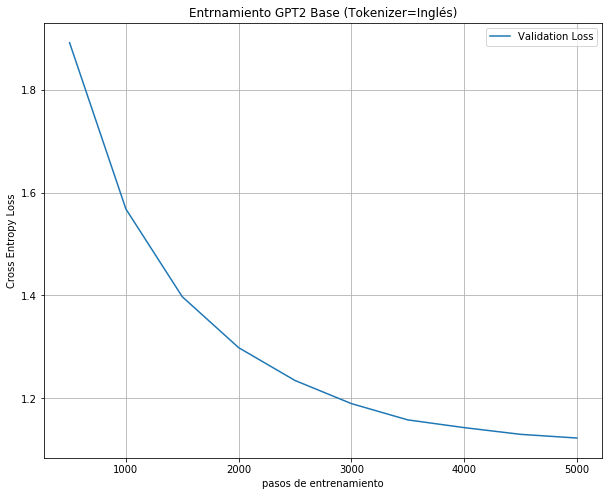

In [4]:

metrics= np.array(
[[500,3.997869,1.891722],
[1000,3.172658,1.568079],
[1500,2.904457,1.397502],
[2000,2.743234,1.298466],
[2500,2.636571,1.234627],
[3000,2.569133,1.189672],
[3500,2.506104,1.157998],
[4000,2.46993,1.142962],
[4500,2.438746,1.129909],
[5000,2.420213,1.122694]])



import matplotlib.pyplot as plt


fig,ax = plt.subplots(figsize=(10,8))

#plt.plot(metrics[:,0], metrics[:,1], label='Training Loss')

plt.plot(metrics[:,0], metrics[:,2], label='Validation Loss')

ax.grid()

ax.set(xlabel='pasos de entrenamiento', ylabel='Cross Entropy Loss',
       title='Entrnamiento GPT2 Base (Tokenizer=Inglés)')
plt.yticks(np.arange(1.2, 2, step=0.2))

plt.legend()


In [30]:
trainer.save_model()

In [31]:
# creating directory if it is not present
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
    
model_to_save = model.module if hasattr(model, 'module') else model
output_model_file = os.path.join(output_dir, WEIGHTS_NAME)
output_config_file = os.path.join(output_dir, CONFIG_NAME)

# save model and model configs
model.save_pretrained(output_dir)
model_to_save.config.to_json_file(output_config_file)

# save tokenizer
tokenizer.save_pretrained(output_dir)

('./4-train-gpt2-en-toke-en-tweets-der/tokenizer_config.json',
 './4-train-gpt2-en-toke-en-tweets-der/special_tokens_map.json',
 './4-train-gpt2-en-toke-en-tweets-der/vocab.json',
 './4-train-gpt2-en-toke-en-tweets-der/merges.txt',
 './4-train-gpt2-en-toke-en-tweets-der/added_tokens.json')

## Probando el modelo

Solo cargamos el modelo si ya fue entrenado, OJO.

In [11]:
#output_dir="./gpt2-derecha-original"
model = AutoModelWithLMHead.from_pretrained(output_dir)
tokenizer = AutoTokenizer.from_pretrained(output_dir)

torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device);

## Aca podemos configurar la libertad en la generación como tamaño máximo, minimo, temperatura, beam search, etc.

In [10]:
bad_words_ids =[ 
    tokenizer.encode('|', add_prefix_space=True)]


def test_model(device, model, text):
    input_ids = tokenizer.encode(text, return_tensors='pt').to(device) # getting out output
    #attention_mask = tokenizer.encode(seeds, return_tensors='pt').to(device)
    
    print("generando beams para input: ", text,"\n==================================================")
    beam_output = model.generate(
        input_ids,
        max_length = 190,
        min_length = 50,
        early_stop=True,
        do_sample=True,
        top_k=100, 
        top_p=0.9,
        num_beams = 10,
        bad_words_ids = bad_words_ids,
        temperature = 1,
        #length_penalty=2,
        no_repeat_ngram_size=2,
        #repetition_penalty=2.0,
        num_return_sequences=10,
        bos_token_id = tokenizer.bos_token_id,
        eos_token_id = tokenizer.eos_token_id,
        pad_token_id =tokenizer.pad_token_id
    )
    
    decoded_beams = []
    
    
    for beam in beam_output:   
        decoded_beams.append({'text':text, 'generado':tokenizer.decode(beam)})
        #print ("\n\n",tokenizer.decode(beam))
        
    return decoded_beams

In [4]:
generated = test_model(device, model, "Con los vecinos de la comuna estamos trabajando ")

generando beams para input:  Con los vecinos de la comuna estamos trabajando  


In [5]:
generated

[{'text': 'Con los vecinos de la comuna estamos trabajando ',
  'generado': 'Con los vecinos de la comuna estamos trabajando  para evitar contagios de #COVIDー19 #QuedateEnCasa #UsaMascarilla @mario_olavarria @CorpColinaSalud  #CuidaTuVida DIDECO va a tu barrio: Un servicio para que hagas consultas y resuelvas tus dudas sobre esta dirección del municipio. Solo se atenderá con permiso de, con mascarilla y manteniendo la distancia. Cupos limitados. El denominado de @Carabdechile ya cuenta con la campaña más grande en nuestra página web.  🔴 AHORA: Alcalde @manueldevia2016 encabezó la entrega de cajas de'},
 {'text': 'Con los vecinos de la comuna estamos trabajando ',
  'generado': 'Con los vecinos de la comuna estamos trabajando  #CuidaTuVida @CorpColinaSalud informa las atenciones que se realizarán, a partir del lunes 8 de junio, en los CESFAM de Alpatacal y Esmeralda, de manera de enfocar sus prestaciones en las personas que más lo requieran. @mario_olavarria @ministeriosalud  🔴AHORA: Al

In [6]:
pd.DataFrame.from_records(generated)

,text,generado
0,Con los vecinos de la comuna estamos trabajando,"Con los vecinos de la comuna estamos trabajando para evitar contagios de #COVIDー19 #QuedateEnCasa #UsaMascarilla @mario_olavarria @CorpColinaSalud #CuidaTuVida DIDECO va a tu barrio: Un servicio para que hagas consultas y resuelvas tus dudas sobre esta dirección del municipio. Solo se atenderá con permiso de, con mascarilla y manteniendo la distancia. Cupos limitados. El denominado de @Carabdechile ya cuenta con la campaña más grande en nuestra página web. 🔴 AHORA: Alcalde @manueldevia2016 encabezó la entrega de cajas de"
1,Con los vecinos de la comuna estamos trabajando,"Con los vecinos de la comuna estamos trabajando #CuidaTuVida @CorpColinaSalud informa las atenciones que se realizarán, a partir del lunes 8 de junio, en los CESFAM de Alpatacal y Esmeralda, de manera de enfocar sus prestaciones en las personas que más lo requieran. @mario_olavarria @ministeriosalud 🔴AHORA: Alcalde @manueldevia2016 entrega detalles de esta situación y las medidas a tomar. #PlanCoronavirus #CuidémonosEntreTodos #QuédateEnCasa🏠 El #MercadoCampesino de @INDAP_Chile ya cuenta con"
2,Con los vecinos de la comuna estamos trabajando,"Con los vecinos de la comuna estamos trabajando #CuidaTuVida @CorpColinaSalud informa las atenciones que se realizarán, a partir del lunes 8 de junio, en los CESFAM de Alpatacal y Esmeralda, de manera de enfocar sus prestaciones en las personas que más lo requieran. @mario_olavarria @ministeriosalud ¡ATENCIÓN VECINOS! La #cuarentena que comenzó el viernes 15 de mayo generó algunas dudas. Esta pandemia hay que tomársela en serio. De ti depende que el #COVID19 pueda ser derrotado. Te dejamos respuestas a las"
3,Con los vecinos de la comuna estamos trabajando,"Con los vecinos de la comuna estamos trabajando en conjunto con el Intendente @UrquietaAtacama y la Gobernadora @cotepuigrredon #CuidaTuVida @CorpColinaSalud informa las atenciones que se realizarán, a partir del lunes 8 de junio, en los CESFAM de Alpatacal y Esmeralda, de manera de enfocar sus prestaciones en las personas que más lo requieran. @mario_olavarria @ministeriosalud 🔹️OPORTUNIDAD LABORAL: Esta pandemia hay que tomársela en serio. El #COVID19 entrega detalles de esta situación y las medidas a to"
4,Con los vecinos de la comuna estamos trabajando,"Con los vecinos de la comuna estamos trabajando para evitar contagios de #COVIDー19 #QuedateEnCasa #UsaMascarilla @mario_olavarria @CorpColinaSalud #CuidaTuVida DIDECO va a tu barrio: Un nuevo servicio para que hagas consultas y resuelvas tus dudas sobre esta dirección del municipio. Solo se atenderá con permiso de, con mascarilla y manteniendo la distancia. Cupos limitados. Llama gratis al 800 104 777 o al correo atencionvecinos@mlareina.cl. #CuidémonosEntreTodos El Intendente @UrquietaAtacama junto al Seremi @SeremiSal"
5,Con los vecinos de la comuna estamos trabajando,"Con los vecinos de la comuna estamos trabajando #CuidaTuVida @CorpColinaSalud informa las atenciones que se realizarán, a partir del lunes 8 de junio, en los CESFAM de Alpatacal y Esmeralda, de manera de enfocar sus prestaciones en las personas que más lo requieran. @mario_olavarria @ministeriosalud 🔹️OPORTUNIDAD LABORAL: Esta pandemia hay que tomársela en serio. Es hora de entrar a la cancha y jugar todos juntos para ganarle al #COVID19. El #MercadoCampesino de @INDAP_Chile ya cuenta con la aplicación"
6,Con los vecinos de la comuna estamos trabajando,"Con los vecinos de la comuna estamos trabajando para evitar el contagio de #COVIDー19 #QuedateEnCasa #UsaMascarilla @mario_olavarria @CorpColinaSalud #CuidaTuVida Sin permiso temporal otorgado por @Carabdechile Sin carnet de identidad en la mano No habrá atención en el municipio. Se entregarán solo 30 números desde las 8:30 horas, de lunes a viernes. Para más información entra a, y sigue el link para comprar una #PermisoDeCirculacionESPECTACIÓN #CuidémonosEntreTodos El #MercadoCampesino de @INDAP_Ch"
7,Con los vecinos de la comuna est

In [12]:
generated = test_model(device, model, "Con los vecinos ")
pd.DataFrame.from_records(generated)

generando beams para input:  Con los vecinos  


,text,generado
0,Con los vecinos,"Con los vecinos #CuidaTuVida @CorpColinaSalud informa las atenciones que se realizarán, a partir del lunes 8 de junio, en los CESFAM de Alpatacal y Esmeralda, de manera de enfocar sus prestaciones en las personas que surgen en esta situación. @mario_olavarria @ministeriosalud 🔹️OPORTUNIDAD LABORAL: Esta pandemia hay que tomársela en serio. De ti depende que el #COVID19 pueda ser derrotado, que podamos estar nuevamente juntos. #QuédateEnCasa🏠 #CuidémonosEntreTodos #PlanCoronavirus�"
1,Con los vecinos,"Con los vecinos vía @emol #CuidaTuVida El @ministeriosalud anunció que el decreto de cuarentena total para Colina se extiende hasta el viernes 26 de junio. Reiteramos las medidas más importantes para cuidarse frente al #COVID19: #LavateLasManos #QuedateEnCasa #UsaMascarilla @mario_olavarria El #MercadoCampesino de @INDAP_Chile ya cuenta con la aplicación YoiFerias: conoce sobre los productos que puedes encontrar, los precios y días que están disponibles. Entra a y comienza a usarla. Te dejamos también un"
2,Con los vecinos,"Con los vecinos!!! #CuidaTuVida Si estás buscando un regalo para tu papá, te invitamos a la Vitrina Virtual del #CentroDelEmprendedor para el #DiaDelPadre. Encuentra ese obsequio perfecto para este día tan especial. Te dejamos también a algunos participantes (1 de 3). @mario_olavarria A esta hora, Gob. @RAMIREZCHILE junto alcalde @SanPedroMuni @manueldevia2016 y diversas autoridades participan en ceremonia de entrega de cajas de mercadería #AlimentosParaChile en la comuna de #Melipilla. #RMdeTodos💪🏼"
3,Con los vecinos,"Con los vecinos @crisghm @MuniLaReina @saracampos @mcatarubio @ConcejalaMunoz @aadelgadom @PamelaGallegosM @ManoloCovarrub @rodolfodelrealm Hola Cris, escríbeme por mensaje directo! Un abrazo #CuidaTuVida @CorpColinaSalud informa las atenciones que se realizarán, a partir del lunes 8 de junio, en los CESFAM de Alpatacal y Esmeralda, de manera de enfocar sus prestaciones en las personas que más lo requieran. @mario_olavarria @ministeriosalud El #MercadoCampesino de @INDAP_"
4,Con los vecinos,"Con los vecinos vía @emol #CuidaTuVida Si estás buscando un regalo para tu papá, te invitamos a la Vitrina Virtual del #CentroDelEmprendedor para el #DiaDelPadre. Encuentra ese obsequio perfecto para este día tan especial. Te dejamos también a algunos participantes (3 de 3). @mario_olavarria 🔹️OPORTUNIDAD LABORAL: A esta hora, Gob. @RAMIREZCHILE junto alcalde @SanPedroMuni @manueldevia2016 y diversas autoridades participan en ceremonia de entrega de cajas de mercadería del @GobiernodeChile en la comuna"
5,Con los vecinos,"Con los vecinos!!! 🔹️ATENCIÓN VECINOS DE VIÑA DEL MAR CIUDAD DEL DEPORTE: Virginia Reginato @mario_olavarria @CorpColinaSalud @colinadeportes #CuidaTuVida El @MinDesarrollo presentó la página, para consultar por el pago del #IngresoDeEmergencia, una importante ayuda en la pandemia de #COVID19. Recuerda que ya no es necesaria la #ClaveUnica para solicitar este beneficio. #QuedateEnCasa #LavateLasManos El #MercadoCampesino de @INDAP_Chile ya cuenta con la aplicación YoiFerias: conoce sobre"
6,Con los vecinos,"Con los vecinos #CuidaTuVida Si estás buscando un regalo para tu papá, te invitamos a la Vitrina Virtual del #CentroDelEmprendedor para el #DiaDelPadre. Encuentra ese obsequio perfecto para este día tan especial. Te dejamos también a algunos participantes (1 de 3). @mario_olavarria @GobiernodeChile @sebastianpinera @ministeriosalud @IntendenciaRM @FelipeGuevaraSt @KarlaEnAccion @MinagriCL @jpguilisasti Hola Gabriela, por favor escríbeme por mensaje directo al teléfono 225927364 o al WhatsApp: +569"
7,Con los vecinos,"Con los vecinos #CuidaTuVida @CorpColinaSalud informa las atenciones que se realizarán, a partir del lunes 8 de junio, en los CESFAM de Alpatacal y Esmeralda, de manera de enfocar sus prestaciones en las personas que más lo requieran. @mario_olavarria @ministeriosalud El #MercadoCampesino de @INDAP_Chile ya cuenta con la aplicación YoiFerias:

## Pruebas adicionales

In [35]:
generated2 = test_model(device, model, "Vamos con todo ")
generated3 = test_model(device, model, "El 27 de enero del año 2010 ")
generated4 = test_model(device, model, "El presidente  ")
generated2, generated3, generated4

generando beams para input:  Vamos con todo  
generando beams para input:  El 27 de enero del año 2010  
generando beams para input:  El presidente   


([{'text': 'Vamos con todo ',
   'generado': 'Vamos con todo izquierda! 🇨🇱  #CuidaTuVida @CorpColinaSalud informa las atenciones que se realizarán en los CESFAM de Alpatacal y Esmeralda, de manera de enfermedad, para resolver dudas sobre el #COVID19. La oficina sigue apoyando la protección de los derechos humanos. @mario_olavarria @MinDesarrollo  [AHORA] Gobernadora @cotepuigrredon, junto a @Carabdechile y @PDI_CHILE, encabezan la entrega de cajas de mercadería de la Provincia de #Melipilla, a partir de las 22:00 horas'},
  {'text': 'Vamos con todo ',
   'generado': 'Vamos con todo!!!  #CuidaTuVida El @MinDesarrollo presentó la página, para consultar por el pago del #IngresoDeEmergencia, una importante ayuda en la pandemia de #COVID19. Recuerda que ya no es necesaria la #ClaveUnica para solicitar este beneficio. @mario_olavarria @CorpColinaSalud  A esta hora, Gob @RAMIREZCHILE junto alcalde @SanPedroMuni @manueldevia2016 y diversas autoridades de la comuna, participan en reunión de tra